In [1]:
%matplotlib inline
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymr import cmr
from cymr import network
from cymr import parameters
from psifr import fr
from cfr import task
from cfr import framework
import importlib

cfr_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(cfr_dir, 'cfr_eeg_mixed.csv')
pattern_file = os.path.join(cfr_dir, 'cfr_patterns.hdf5')
#model_name = 'cmr_fcf-loc-cat_ff-use'
model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat=1-B_rec_use=1'
fit_dir = os.path.join(cfr_dir, 'fits', 'v4', model_name)
param_file = os.path.join(fit_dir, 'parameters.json')

In [2]:
param_def = parameters.read_json(param_file)
results = pd.read_csv(os.path.join(fit_dir, 'fit.csv'), index_col=0)
subj_param = results.T.to_dict()

In [3]:
patterns = network.load_patterns(pattern_file)
data = pd.read_csv(data_file)
labeled = task.label_clean_trials(data)
clean = labeled.query('clean').reset_index()

In [4]:
model = cmr.CMR()
state = model.record(
    clean, {}, subj_param, param_def=param_def, patterns=patterns, include=['c', 'c_in']
)
print(f'data:  {len(clean)}')
print(f'state: {len(state)}')

data:  31307
state: 31307


In [5]:
c = np.array([s.c for s in state])
c_in = np.array([s.c_in for s in state])
net = state[0]
c_slice = net.get_slice('c', 'use', 'item')

In [15]:
subj_data = fr.filter_data(clean, subjects=[1], trial_type='study')
evidence = framework.classify_patterns(subj_data, c_in[subj_data.index, c_slice])

In [16]:
import importlib
importlib.reload(task)
labeled = task.label_train_category(subj_data.reset_index(drop=True))
labeled = task.label_block(labeled)
res = pd.concat([labeled, evidence], axis=1)
res

,index,subject,list,position,trial_type,item,item_index,session,list_type,category,...,clean,prev,base,block,n_block,block_pos,block_len,cel,loc,obj
0,0,1,2,1,study,SEAN PENN,228,1,mixed,cel,...,True,NaN,NaN,1,6,1,2,9.995313e-01,0.000380,0.000089
1,1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,...,True,NaN,NaN,1,6,2,2,9.941298e-01,0.002505,0.003365
2,2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,...,True,cel,NaN,2,6,1,4,5.094559e-07,0.999589,0.000411
3,3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,...,True,cel,NaN,2,6,2,4,3.841652e-08,0.999917,0.000083
4,4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,...,True,cel,NaN,2,6,3,4,3.621157e-05,0.993901,0.006063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1062,1,48,20,study,CHE GUEVARA,51,3,mixed,cel,...,True,obj,cel,5,6,5,5,9.744192e-01,0.021467,0.004114
716,1063,1,48,21,study,OAHU BEACH,406,3,mixed,loc,...,True,cel,obj,6,6,1,4,1.840192e-03,0.994541,0.003619
717,1064,1,48,22,study,GATEWAY ARCH,324,3,mixed,loc,...,True,cel,obj,6,6,2,4,2.703837e-06,0.999904,0.000094
718,1065,1,48,23,study,WHITE HOUSE,501,3,mixed,loc,...,True,cel,obj,6,6,3,4,3.381007e-03,0.995797,0.000822


In [17]:
res['evid_curr'] = np.nan
res['evid_prev'] = np.nan
res['evid_base'] = np.nan
categories = res['category'].unique()
for cat in categories:
    include = res['category'] == cat
    res.loc[include, 'evid_curr'] = evidence.loc[include, cat]
    
    include = res['prev'] == cat
    res.loc[include, 'evid_prev'] = evidence.loc[include, cat]
    
    include = res['base'] == cat
    res.loc[include, 'evid_base'] = evidence.loc[include, cat]

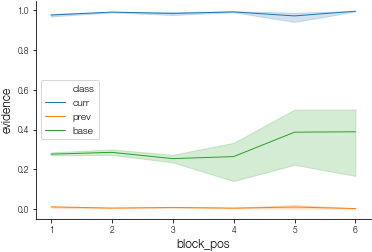

In [18]:
import seaborn as sns
m = pd.concat([
    res.groupby(['category', 'block_pos'])['evid_curr'].mean(),
    res.groupby(['category', 'block_pos'])['evid_prev'].mean(),
    res.groupby(['category', 'block_pos'])['evid_base'].mean()
], keys=['curr', 'prev', 'base'])
mdf = pd.DataFrame(m, columns=['evidence'])
mdf.index.rename(['class', 'categegory', 'block_pos'], inplace=True)
sns.lineplot(x='block_pos', y='evidence', hue='class', data=pd.DataFrame(mdf).reset_index())
#pd.DataFrame(m)
#m

In [32]:
mdf

evidence
class categegory block_pos          
curr  cel        1          0.295540
                 2          0.465918
                 3          0.609523
                 4          0.703979
                 5          0.789953
                 6          0.825571
      loc        1          0.291543
                 2          0.481355
                 3          0.602527
                 4          0.718916
                 5          0.668355
                 6          0.820414
      obj        1          0.273954
                 2          0.448706
                 3          0.605743
                 4          0.735184
                 5          0.838493
                 6          0.858432
prev  cel        1          0.547987
                 2          0.423578
                 3          0.305252
                 4          0.218414
                 5          0.171816
                 6          0.135084
      loc        1          0.511745
                 2          0.381842
                 3          0.308945
                 4          0.224942
                 5          0.223786
                 6          0.120532
      obj        1          0.568663
                 2          0.438957
                 3          0.321189
                 4          0.220957
                 5          0.116858
                 6          0.082637
base  cel        1          0.275483
                 2          0.279998
                 3          0.252737
                 4          0.208971
                 5          0.215081
                 6          0.134216
      loc        1          0.319186
                 2          0.331280
                 3          0.295972
                 4          0.318176
                 5          0.441710
                 6          0.506612
      obj        1          0.290430
                 2          0.292632
                 3          0.266198
                 4          0.329547
                 5          0.487402
                 6          0.515539

In [26]:
fr.filter_data(res, lists=[2])

,index,subject,list,position,trial_type,item,item_index,session,list_type,category,...,prev,base,cel,loc,obj,evid_curr,evid_prev,evid_base,block,block_pos
0,0,1,2,1,study,SEAN PENN,228,1,mixed,cel,...,NaN,NaN,0.615722,0.162244,0.222034,0.615722,NaN,NaN,1,1
1,1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,...,NaN,NaN,0.697957,0.164269,0.137774,0.697957,NaN,NaN,1,2
2,2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,...,cel,NaN,0.516469,0.362378,0.121153,0.362378,0.516469,NaN,2,1
3,3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,...,cel,NaN,0.271971,0.658268,0.0697616,0.658268,0.271971,NaN,2,2
4,4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,...,cel,NaN,0.213319,0.726328,0.0603527,0.726328,0.213319,NaN,2,3
5,5,1,2,6,study,BRYCE CANYON,281,1,mixed,loc,...,cel,NaN,0.110213,0.849163,0.0406242,0.849163,0.110213,NaN,2,4
6,6,1,2,7,study,TROPHY,745,1,mixed,obj,...,loc,cel,0.153736,0.796341,0.0499222,0.0499222,0.796341,0.153736,3,1
7,7,1,2,8,study,BRUSH,548,1,mixed,obj,...,loc,cel,0.131979,0.745161,0.12286,0.12286,0.745161,0.131979,3,2
8,8,1,2,9,study,SUPREME COURT,469,1,mixed,loc,...,obj,loc,0.141279,0.729298,0.129423,0.729298,0.129423,0.729298,4,1
9,9,1,2,10,study,SAN FRANCISCO,444,1,mixed,loc,...,obj,loc,0.103121,0.826474,0.0704048,0.826474,0.0704048,0.826474,4,2


In [15]:
res.groupby([''])

,index,subject,list,position,trial_type,item,item_index,session,list_type,category,...,list_category,clean,prev,base,cel,loc,obj,evid_curr,evid_prev,evid_base
0,0,1,2,1,study,SEAN PENN,228,1,mixed,cel,...,mixed,True,NaN,NaN,0.615722,0.162244,0.222034,0.615722,NaN,NaN
1,1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,...,mixed,True,NaN,NaN,0.697957,0.164269,0.137774,0.697957,NaN,NaN
2,2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,...,mixed,True,cel,NaN,0.516469,0.362378,0.121153,0.362378,0.516469,NaN
3,3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,...,mixed,True,cel,NaN,0.271971,0.658268,0.0697616,0.658268,0.271971,NaN
4,4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,...,mixed,True,cel,NaN,0.213319,0.726328,0.0603527,0.726328,0.213319,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,1073,1,48,7,recall,OAHU BEACH,406,3,mixed,loc,...,mixed,True,NaN,NaN,0.0533905,0.827822,0.118787,0.827822,NaN,NaN
1059,1074,1,48,8,recall,HOLLYWOOD,344,3,mixed,loc,...,mixed,True,NaN,NaN,0.226118,0.595328,0.178555,0.595328,NaN,NaN
1060,1075,1,48,9,recall,WESTMINSTER ABBEY,499,3,mixed,loc,...,mixed,True,NaN,NaN,0.261584,0.656687,0.0817285,0.656687,NaN,NaN
1061,1076,1,48,10,recall,ELIZABETH TAYLOR,84,3,mixed,cel,...,mixed,True,NaN,NaN,0.120825,0.741818,0.137357,0.120825,NaN,NaN


In [ ]:
res_list = []
for subject, subj_data in clean.groupby('subject'):
    

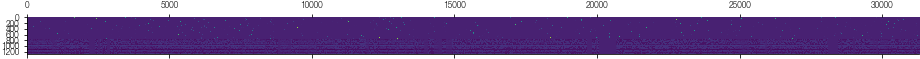

In [11]:
plt.matshow(c.T)

In [8]:
state[0]

f:
task: 25 units
    item: 24 units
    start: 1 units

c:
loc: 769 units
    item: 768 units
    start: 1 units
cat: 4 units
    item: 3 units
    start: 1 units
use: 513 units
    item: 512 units
    start: 1 units

In [5]:
clean_data = subj_data.query('clean')
study_inc = clean_data['trial_type'] == 'study'
study_data = clean_data.loc[study_inc]
c = np.array([s.c for s in state])
c_study = c[study_inc]
labels = study_data['category'].to_numpy()

In [6]:
print(study_data.shape)
print(c_study.shape)

(48, 13)
(48, 1286)


In [7]:
from sklearn import svm
train_inc = study_data['list'] == 9
test_inc = study_data['list'] == 10
clf = svm.SVC(probability=True)
clf.fit(c_study[train_inc], labels[train_inc])

SVC(probability=True)

In [8]:
clf.predict(c_study[test_inc])

array(['cel', 'cel', 'cel', 'loc', 'loc', 'obj', 'obj', 'obj', 'loc',
       'loc', 'cel', 'cel', 'cel', 'obj', 'obj', 'obj', 'loc', 'loc',
       'loc', 'loc', 'obj', 'obj', 'cel', 'cel'], dtype=object)

In [9]:
labels[test_inc]

array(['cel', 'cel', 'cel', 'loc', 'loc', 'obj', 'obj', 'obj', 'loc',
       'loc', 'cel', 'cel', 'cel', 'obj', 'obj', 'obj', 'loc', 'loc',
       'loc', 'loc', 'obj', 'obj', 'cel', 'cel'], dtype=object)

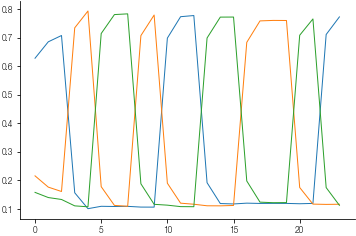

In [10]:
plt.plot(clf.predict_proba(c_study[test_inc]))

In [13]:
classes = clf.classes_

In [14]:
prob = clf.predict_proba(c_study[test_inc])

In [15]:
pd.DataFrame(prob, columns=classes)

,cel,loc,obj
0,0.627372,0.215262,0.157366
1,0.684873,0.175813,0.139313
2,0.706976,0.160485,0.132539
3,0.155957,0.733901,0.110142
4,0.100295,0.792837,0.106869
5,0.108627,0.177439,0.713934
6,0.107958,0.111723,0.780318
7,0.108434,0.108724,0.782842
8,0.105869,0.706656,0.187475
9,0.105717,0.778741,0.115542


In [37]:
np.nan == 4

False

In [65]:
from cfr import task
import importlib
importlib.reload(task)
category = labels[train_inc]
%pdb off
prev, base = task.get_train_category(category)
print(np.vstack([category, prev, base]).T)

Automatic pdb calling has been turned OFF
[['loc' '' '']
 ['loc' '' '']
 ['obj' 'loc' '']
 ['obj' 'loc' '']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['obj' 'cel' 'obj']
 ['obj' 'cel' 'obj']
 ['loc' 'obj' 'cel']
 ['loc' 'obj' 'cel']
 ['cel' 'loc' 'obj']
 ['cel' 'loc' 'obj']]


In [66]:
labeled = task.label_train_category(clean_data)
labeled

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean,prev,base
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,True,NaN,NaN
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,True,NaN,NaN
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,True,loc,NaN
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,True,loc,NaN
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,True,obj,loc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1,10,2,recall,DOLLY PARTON,78,1,mixed,cel,4.0,0.601,mixed,True,NaN,NaN
249,1,10,4,recall,MATT DAMON,173,1,mixed,cel,4.0,0.727,mixed,True,NaN,NaN
250,1,10,5,recall,THE VENETIAN,475,1,mixed,loc,4.0,0.949,mixed,True,NaN,NaN
251,1,10,6,recall,STAPLE REMOVER,720,1,mixed,obj,3.0,1.106,mixed,True,NaN,NaN


In [64]:
labeled['prev'].astype('category')

185    NaN
186    NaN
187    loc
188    loc
189    obj
      ... 
247    NaN
249    NaN
250    NaN
251    NaN
252    NaN
Name: prev, Length: 65, dtype: category
Categories (3, object): [cel, loc, obj]

In [47]:
pd.Series(['a', 'b', 'c'], dtype='string')

0    a
1    b
2    c
dtype: string

In [51]:
labeled['prev'].astype('string')

185        
186        
187     loc
188     loc
189     obj
       ... 
247    <NA>
249    <NA>
250    <NA>
251    <NA>
252    <NA>
Name: prev, Length: 65, dtype: string

In [41]:
pd.__version__

'1.0.3'

In [19]:
labeled = study_data.copy()
for (subject, trial), list_data in study_data.groupby(['subject', 'list']):
    labeled.loc[list_data.index, 'new'] = list_data['list'].to_numpy() * 2
labeled

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean,new
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,True,18.0
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,True,18.0
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,True,18.0
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,True,18.0
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,True,18.0
190,1,9,6,study,DAN RATHER,65,1,mixed,cel,3.0,0.634,mixed,True,18.0
191,1,9,7,study,VIENNA,492,1,mixed,loc,3.0,0.751,mixed,True,18.0
192,1,9,8,study,PLACE DE LA CONCORDE,424,1,mixed,loc,3.0,0.705,mixed,True,18.0
193,1,9,9,study,GREAT SALT LAKE,338,1,mixed,loc,2.0,0.716,mixed,True,18.0
194,1,9,10,study,SIENA,451,1,mixed,loc,3.0,0.579,mixed,True,18.0


In [22]:
from psifr import fr

In [21]:
clf = svm.SVC(probability=True)
curr = np.zeros(len(labels))
prev = np.zeros(len(labels))
base = np.zeros(len(labels))
for train, test in logo.split(c_study, labels, groups):
    clf.fit(c_study[train], labels[train])
    x = clf.predict_proba(c_study[test])
    print(x)

NameError: name 'logo' is not defined

> <ipython-input-21-ea526f168f84>(5)<module>()
      3 prev = np.zeros(len(labels))
      4 base = np.zeros(len(labels))
----> 5 for train, test in logo.split(c_study, labels, groups):
      6     clf.fit(c_study[train], labels[train])
      7     x = clf.predict_proba(c_study[test])



ipdb>  q


In [ ]:
help(logo.split)

In [ ]:
from sklearn import model_selection as ms
groups = study_data['list'].to_numpy()
logo = ms.LeaveOneGroupOut()
clf = svm.SVC(probability=True)
res = ms.cross_validate(clf, c_study, labels, groups=groups, cv=logo)

In [ ]:
res

In [ ]:
help(svm.SVC)

In [ ]:
subj_data.loc[subj_data['clean'], 'state'] = state

In [ ]:
subj_data

In [ ]:
net = state[0]
c = np.empty((subj_data.shape[0], net.n_c))
c[:] = np.nan
for i, trial_state in enumerate(subj_data['state'].to_list()):
    if isinstance(trial_state, float):
        continue
    c[i, :] = trial_state.c
#pd.concat((subj_data, ))

In [ ]:
plt.matshow(c)
c.shape

In [ ]:
pd.concat((subj_data, c))

In [ ]:
c = np.array([s.c for s in state])
fig, ax = plt.subplots()
ax.matshow(c);

In [ ]:
fig, ax = plt.subplots()
segment_ind = state[0].get_segment('c', 'cat', 'item')
ind = slice(*tuple(segment_ind))
ax.plot(c[:23, ind]);

In [ ]:
segment_ind = state[0].get_segment('c', 'use', 'item')
ind = slice(*tuple(segment_ind))
fig, ax = plt.subplots(figsize=(12, 6))
ax.matshow(c[:23, ind]);

In [ ]:
ind1 = fr.filter_data(subj_data, lists=[9], trial_type='study').index
rel_ind1 = np.nonzero(subj_data.index.isin(ind1))
ind2 = fr.filter_data(subj_data, lists=[10], trial_type='study').index
rel_ind2 = np.nonzero(subj_data.index.isin(ind2))

In [ ]:
state_array = np.asarray(state)
state1 = np.array([s.c[ind] for s in state_array[rel_ind1]])
state2 = np.array([s.c[ind] for s in state_array[rel_ind2]])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 4))
ax[0].matshow(state1)
ax[1].matshow(state2)

In [ ]:
plt.matshow(1 - sd.squareform(sd.pdist(state1, 'correlation')))
plt.colorbar()

In [ ]:
plt.matshow(1 - sd.squareform(sd.pdist(state2, 'correlation')))
plt.colorbar()

In [ ]:
fig, ax = plt.subplots()
ax.matshow(patterns['vector']['use'])

In [ ]:
import scipy.spatial.distance as sd
plt.matshow(sd.squareform(sd.pdist(patterns['vector']['use'], 'euclidean')))

In [ ]:
from sklearn.svm import LinearSVC
cls = LinearSVC()
cls.train(state1)

In [ ]:
c_list = []
for i, state in sub_data['state'].items():
    if isinstance(state, float):
        continue
    c_list.append(state.c)
c = np.array(c_list)
c.shape

In [ ]:
lists = subj_data['list'].unique()
data_len = []
state_len = []
for l in lists:
    sub_data = fr.filter_data(subj_data, lists=l)
    state = model.record(sub_data, subj_param, param_def=param_def, patterns=patterns)
    data_len.append(len(sub_data))
    state_len.append(len(state))

In [ ]:
pd.DataFrame({'data': data_len, 'state': state_len}, index=lists)

In [ ]:
len(state)